# Import

reference: https://www.datacamp.com/tutorial/introduction-to-autoencoders

In [32]:
import torch
from torch import nn
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.neural_network import MLPClassifier

In [3]:
ROOT = os.getcwd()
DATASET_PATH = os.path.join(ROOT, 'dataset', 'weatherAUS.csv')
assert os.path.exists(DATASET_PATH), f'path to dataset not found {DATASET_PATH}'


In [4]:
df = pd.read_csv(DATASET_PATH)
print(df.shape)
df.head()

(145460, 23)


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


# Check missing values

In [5]:
df.isna().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

In [6]:
newdf = df.select_dtypes(include='number')
newdf['RainToday'] = df['RainToday']
newdf['RainTomorrow'] = df['RainTomorrow']
print(newdf.shape)
newdf.head()

(145460, 18)


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,13.4,22.9,0.6,NaN,NaN,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,7.4,25.1,0.0,NaN,NaN,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,12.9,25.7,0.0,NaN,NaN,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,9.2,28.0,0.0,NaN,NaN,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,17.5,32.3,1.0,NaN,NaN,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [7]:
newdf.dropna(how = 'any', inplace=True)
newdf.loc[newdf['RainToday'] == 'No', 'RainToday'] = 0
newdf.loc[newdf['RainToday'] == 'Yes', 'RainToday'] = 1
newdf.loc[newdf['RainTomorrow'] == 'No', 'RainTomorrow'] = 0
newdf.loc[newdf['RainTomorrow'] == 'Yes', 'RainTomorrow'] = 1
print(newdf.shape)
newdf.head()


(58090, 18)


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
6049,17.9,35.2,0.0,12.0,12.3,48.0,6.0,20.0,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,0,0
6050,18.4,28.9,0.0,14.8,13.0,37.0,19.0,19.0,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,0,0
6052,19.4,37.6,0.0,10.8,10.6,46.0,30.0,15.0,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,0,0
6053,21.9,38.4,0.0,11.4,12.2,31.0,6.0,6.0,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,0,0
6054,24.2,41.0,0.0,11.2,8.4,35.0,17.0,13.0,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,37.6,0,0


In [8]:
target = 'RainTomorrow'
X = newdf.drop(target, axis = 1)
y = np.array(newdf[target], dtype = 'float32')

scaler = StandardScaler() 
X = scaler.fit_transform(X)

X = torch.tensor(X, dtype = torch.float32)
y = torch.tensor(y, dtype = torch.float32)

print('X shape = ', X.shape)
print(X[:2])
print('y shape = ', y.shape)
print(y[:10])

X shape =  torch.Size([58090, 17])
tensor([[ 0.7052,  1.5873, -0.3029,  1.7757,  1.2220,  0.5560, -1.0776,  0.0487,
         -2.4811, -1.8150, -1.5903, -1.5191, -0.8017,  0.2536,  1.2890,  1.5755,
         -0.5307],
        [ 0.7825,  0.6838, -0.3029,  2.5343,  1.4079, -0.2659,  0.4379, -0.0680,
         -1.9443, -2.0623, -0.6391, -0.4031, -1.1584, -1.2556,  0.3352,  0.6392,
         -0.5307]])
y shape =  torch.Size([58090])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


# Autoencoder

In [38]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size = 16, encode_size = 3) -> None:
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, encode_size),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encode_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid() #NOTE: why use sigmoid here?
        )
    
    def forward(self, X):
        X = self.encoder(X)
        return self.decoder(X)

In [57]:
def tune(input_size, hidden_size, encode_size, lr, epochs = 1000):

    model = Autoencoder(input_size = input_size, encode_size = encode_size)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)

    num_epochs = 20

    loop = tqdm(range(epochs))
    losses = []
    for e in loop:

        X_pred = model(X)

        loss = criterion(X_pred, X)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        loop.set_description(f'e = {e}, loss = {loss.item():.3f}')

    sns.lineplot(y = losses, x =list(range(len(losses))))
    plt.title("Loss")
    plt.show()

    return model

def compare_performance(autoencoder, X, y):
    encoded_data = autoencoder.encoder(X).detach().numpy()
    model2 = MLPClassifier()
    model2.fit(encoded_data, y)
    print('encoded score = ', model2.score(encoded_data,y))


In [52]:
model1 = MLPClassifier()
model1.fit(X,y)
print('original score = ', model1.score(X,y))

original score =  0.8713203649509382


# Hyperparams Tunning #1, change hidden size

e = 999, loss = 0.648: 100%|██████████| 1000/1000 [00:18<00:00, 53.67it/s]


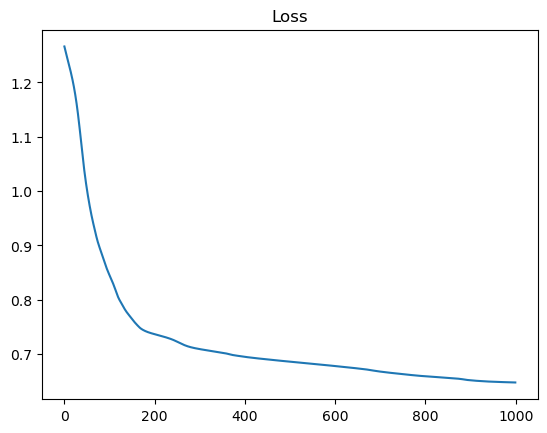

encoded score =  0.8269925976932346


In [59]:
input_size = X.shape[1]
hidden_size = 16
encode_size = 3
lr = 0.003
autoencoder = tune(input_size, hidden_size, encode_size, lr = lr)
compare_performance(autoencoder, X,y)

e = 999, loss = 0.649: 100%|██████████| 1000/1000 [00:18<00:00, 53.60it/s]


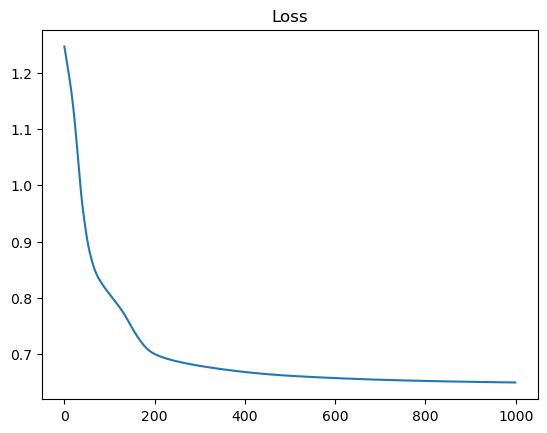

encoded score =  0.8219487002926493


In [60]:
input_size = X.shape[1]
hidden_size = 32
encode_size = 3
lr = 0.003
autoencoder = tune(input_size, hidden_size, encode_size, lr = lr)
compare_performance(autoencoder, X,y)

e = 999, loss = 0.643: 100%|██████████| 1000/1000 [00:20<00:00, 49.38it/s]


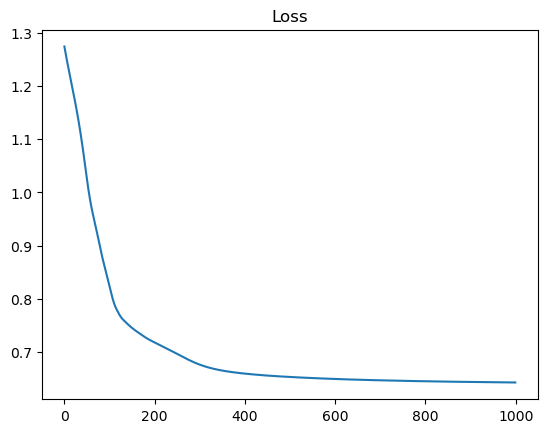

encoded score =  0.8191943535892581


In [61]:
input_size = X.shape[1]
hidden_size = 64
encode_size = 3
lr = 0.003
autoencoder = tune(input_size, hidden_size, encode_size, lr = lr)
compare_performance(autoencoder, X,y)

In [42]:
# 3d plot, only works with 3 dimensions
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')


# ax.scatter(encoded_data[:, 0], encoded_data[:,1], encoded_data[:,2], c = y)

# ax.set_xlabel('dim 0 ')
# ax.set_ylabel('dim 1')
# ax.set_zlabel('dim 2')

# plt.show()

# Hyperparams Tunning #2, change embed size

e = 999, loss = 0.728: 100%|██████████| 1000/1000 [00:16<00:00, 61.89it/s]


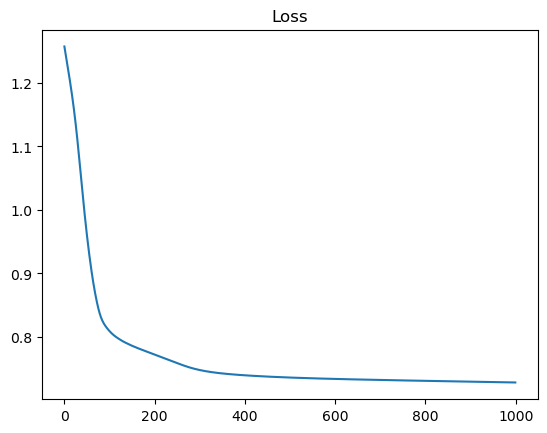

encoded score =  0.8073334480977793


In [64]:
input_size = X.shape[1]
hidden_size = 16
encode_size = 2 
lr = 0.003
autoencoder = tune(input_size, hidden_size, encode_size, lr = lr)
compare_performance(autoencoder, X,y)

e = 999, loss = 0.667: 100%|██████████| 1000/1000 [00:18<00:00, 53.49it/s]


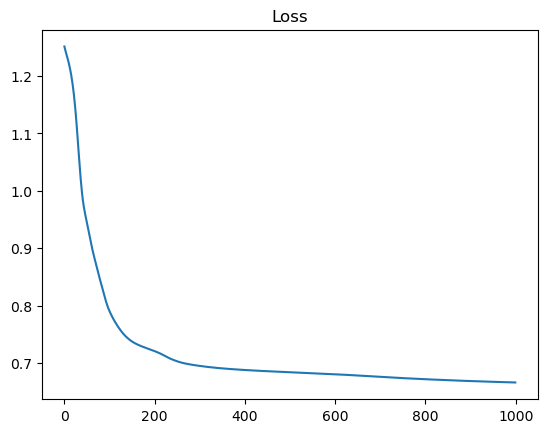

encoded score =  0.8372181098295748


In [62]:
input_size = X.shape[1]
hidden_size = 16
encode_size = 4
lr = 0.003
autoencoder = tune(input_size, hidden_size, encode_size, lr = lr)
compare_performance(autoencoder, X,y)

e = 999, loss = 0.607: 100%|██████████| 1000/1000 [00:16<00:00, 58.95it/s]


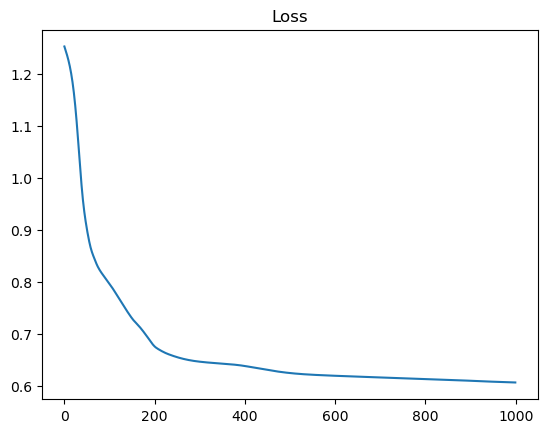

encoded score =  0.847357548631434


In [63]:
input_size = X.shape[1]
hidden_size = 16
encode_size = 5
lr = 0.003
autoencoder = tune(input_size, hidden_size, encode_size, lr = lr)
compare_performance(autoencoder, X,y)

# Hyperparams Tunning #3 change lr and epochs

e = 7999, loss = 0.671: 100%|██████████| 8000/8000 [02:38<00:00, 50.57it/s]


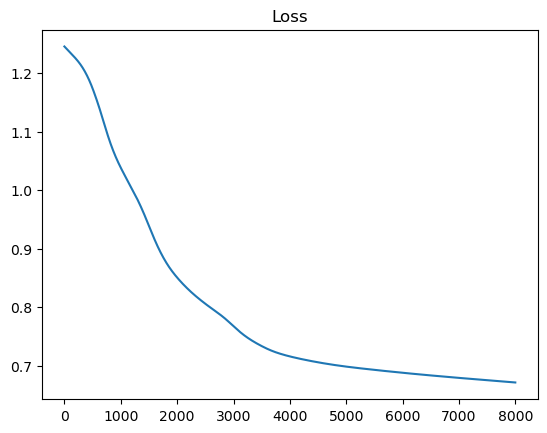

encoded score =  0.8229471509726287


In [69]:
input_size = X.shape[1]
hidden_size = 16
encode_size = 3
lr = 1e-4
epochs = 8000
autoencoder = tune(input_size, hidden_size, encode_size, lr = lr, epochs = epochs)
compare_performance(autoencoder, X,y)